# Persiapan

In [1]:
# Menyiapkan library yang akan digunakan
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import zipfile
import random
import time
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from google.colab import files
from google.colab import drive
from shutil import copyfile
from pathlib import Path
drive.mount('drive/')

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [2]:
# Meyiapkan dataset
!wget --no-check-certificate \
    'https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip' \
    -O '/tmp/rockpaperscissors.zip'

local_zip = '/tmp/rockpaperscissors.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/rockpaperscissors/rps-cv-images/'

--2021-06-05 13:43:46--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  19.5MB/s    in 17s     

2021-06-05 13:44:03 (18.6 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.4,
      height_shift_range=0.4,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='wrap',
      validation_split=.4,
      preprocessing_function=preprocess_input
      )

train_generator = train_datagen.flow_from_directory(
      base_dir,
      shuffle=True,
      class_mode='categorical',
      target_size=(150, 150),
      subset='training',
      seed=42
      )

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.4,
      height_shift_range=0.4,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='wrap',
      validation_split=.4,
      preprocessing_function=preprocess_input
      )

validation_generator = validation_datagen.flow_from_directory(      
      base_dir,      
      class_mode='categorical',
      target_size=(150, 150),
      subset='validation',
      seed=42
      )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


# Pembuatan Model

In [4]:
def waktu_running(mulai, selesai, argumen='Total waktu train model:'):
    total_waktu = selesai - mulai
    total_waktu_s = total_waktu
    satuan = 'detik'
    if total_waktu > 60 and total_waktu < 3600:
        total_waktu = total_waktu/60
        satuan = 'menit'
    if total_waktu > 3600:
        total_waktu = total_waktu/3600
        satuan = 'jam'
    print('{} {} {}'.format(argumen, total_waktu, satuan))

In [5]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy')>=0.98 and (abs(logs.get('val_accuracy')-logs.get('accuracy')) <= 0.01):
      print('\nAkurasi validasi sudah 98% dengan perbedaan < 1% dari akurasi training ... \nProses training berhenti!')
      self.model.stop_training = True

In [6]:
# layer konvolusi untuk ekstraksi fitur dengan pretrained vgg16
conv_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in conv_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([             
              conv_model,
              tf.keras.layers.Flatten(),              
              tf.keras.layers.Dense(1024, activation='relu'),              
              tf.keras.layers.Dense(512, activation='relu'),
              tf.keras.layers.Dense(512, activation='relu'),
              tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(
              optimizer=tf.keras.optimizers.Adamax(), #RMSprop(),
              loss='categorical_crossentropy', 
              metrics=['accuracy']
              )

t0 = time.time()
history = model.fit(
              train_generator,
              validation_data = validation_generator,
              steps_per_epoch = 32,
              epochs = 150,              
              validation_steps = 8,
              verbose = 1,    
              callbacks=[myCallback()]
              )
t1 = time.time()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 23,893,315
Trainable params: 9,178,627
Non-trainable params: 14,714,688
____________________________________

In [7]:
waktu_running(t0,t1)

Total waktu train model: 6.011197682221731 menit


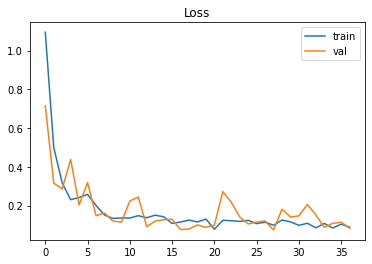

In [8]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

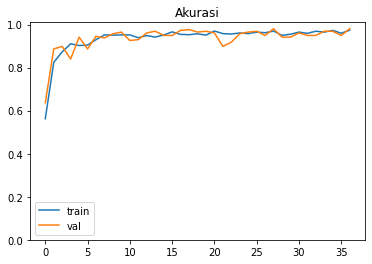

In [9]:
plt.title('Akurasi')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.ylim(0,1.01)
plt.legend()
plt.show()

# Test

In [10]:
def prediksi(img_):
  img = image.load_img(img_, target_size=(150,150))  

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images)
    
  if classes.argmax()==0:
    label='Kertas'
  elif classes.argmax()==1:
    label='Batu'
  else:
    label='Gunting'

  print(classes)
  print('Ini adalah gambar {}'.format(label))

Saving images (1).jpg to images (1).jpg
[[1.0000000e+00 0.0000000e+00 4.0601737e-38]]
Ini adalah gambar Kertas


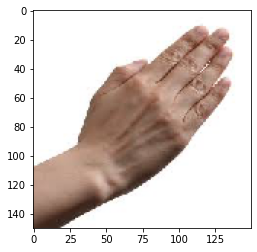

In [18]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  prediksi(fn)